In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import utils.db_connection as db

In [12]:
model_path = os.path.join('models', 'transformer_tunned_model.keras')

# ---------- 1. Data Loading & Preprocessing ----------
# Ensure working directory contains 'flights_cleaned.csv'
df =  db.read_db("flights_cleaned")
df.head()

,latitude,longitude,datetime,gps_altitude_m,distance_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,glide_ratio,bearing,delta_bearing,elapsed_time,delta_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
0,36.980983,29.314417,2020-07-03 07:42:24,2083,7.545830,27.164986,-2.0,0.0,-2.0,3.772915,11,3.0,17.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
1,36.981050,29.314450,2020-07-03 07:42:25,2082,7.971536,28.697530,-3.0,0.0,-3.0,2.657179,21,10.0,18.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
2,36.981150,29.314500,2020-07-03 07:42:26,2080,11.957302,43.046289,-2.0,0.0,-2.0,5.978651,21,0.0,19.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
3,36.981217,29.314567,2020-07-03 07:42:27,2079,9.485179,34.146645,-1.0,-14.0,-1.0,9.485179,38,17.0,20.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
4,36.981283,29.314633,2020-07-03 07:42:28,2078,9.485176,34.146634,0.0,-14.0,0.0,0.000000,38,0.0,21.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0


In [13]:
# Separate features and target
target_col = 'climb_rate_m/s'
feature_cols = [
    'gps_altitude_m', 'distance_m', 'speed_km/s',
    'glide_ratio', 'bearing', 'delta_bearing',
    'temp', 'pressure', 'humidity', 'dew_point',
    'wind_speed', 'wind_deg'
]
X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

# Train-test split
split_frac = 0.8
split_idx = int(len(X) * split_frac)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Save scaler
os.makedirs('models', exist_ok=True)
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [14]:

# ---------- 2. Create sliding-window datasets ----------
T = 10  # sequence length
batch_size = 32
train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train, y_train,
    sequence_length=T,
    sequence_stride=1,
    batch_size=batch_size,
    shuffle=False
)
test_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test, y_test,
    sequence_length=T,
    sequence_stride=1,
    batch_size=batch_size,
    shuffle=False
)


In [15]:

# ---------- 3. Positional Encoding ----------
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i   = np.arange(d_model)[None, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
    angle_rads = pos * angle_rates
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    return tf.cast(np.concatenate([sines, cosines], axis=-1), tf.float32)


In [16]:

# ---------- 4. Build Transformer Model ----------
seq_len = T
n_feats = X.shape[1]
d_model = 64
num_heads = 4

def build_transformer(seq_len, n_feats, d_model, num_heads):
    inp = layers.Input(shape=(seq_len, n_feats))
    x = layers.Dense(d_model)(inp)
    pos_enc = get_positional_encoding(seq_len, d_model)
    x = x + pos_enc
    # Encoder block
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn = tf.keras.Sequential([
        layers.Dense(d_model*2, activation='relu'),
        layers.Dense(d_model)
    ])
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn(x))
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name='Transformer')

model = build_transformer(seq_len, n_feats, d_model, num_heads)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 64)    │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     66,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 10, 64)    │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,097 (328.50 KB)

 Trainable params: 84,097 (328.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ---------- 5. Train ----------
callbacks = [
    EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True),
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_mae',
        save_best_only=True
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 370s 10ms/step - loss: 2.1752 - mae: 1.0429 - val_loss: 2.5356 - val_mae: 0.9279
Epoch 2/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 365s 10ms/step - loss: 1.4699 - mae: 0.7501 - val_loss: 2.0884 - val_mae: 0.8194
Epoch 3/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 382s 10ms/step - loss: 1.3748 - mae: 0.7018 - val_loss: 2.0913 - val_mae: 0.8300
Epoch 4/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 380s 10ms/step - loss: 1.1907 - mae: 0.6443 - val_loss: 0.8116 - val_mae: 0.5167
Epoch 5/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 390s 10ms/step - loss: 0.6957 - mae: 0.4531 - val_loss: 0.7343 - val_mae: 0.4377
Epoch 6/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 320s 8ms/step - loss: 0.5941 - mae: 0.3866 - val_loss: 0.7291 - val_mae: 0.4708
Epoch 7/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 325s 9ms/step - loss: 0.5267 - mae: 0.3581 - val_loss: 0.6442 - val_mae: 0.3895
Epoch 8/15
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 324s 9ms/step - loss: 0.4857 - mae: 0.3378 - val_loss: 0.5927 - val_mae: 0.3590
Epo

In [20]:

# ---------- 6. Save Model ----------
model.save(model_path)
print(f'Model saved to {model_path}')

# ---------- 7. Evaluate & Plot Errors ----------
y_pred = model.predict(test_ds).flatten()
y_true = np.concatenate([y for _, y in test_ds], axis=0)

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print(f'Test MAE: {mae:.4f}, RMSE: {rmse:.4f}')


Model saved to models\transformer_tunned_model.keras
9481/9481 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
Test MAE: 0.3590, RMSE: 0.7699


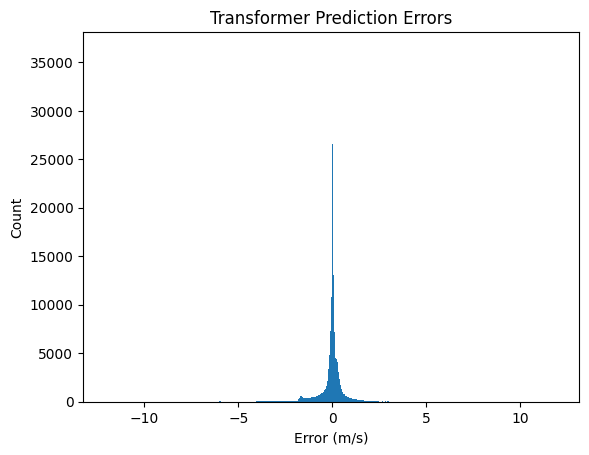

In [21]:
# Error histogram
errors = y_true - y_pred
plt.figure()
plt.hist(errors, bins=1000)
plt.title('Transformer Prediction Errors')
plt.xlabel('Error (m/s)')
plt.ylabel('Count')
plt.show()